In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [1]:
!pip install xgboost

In [2]:
!pip install keras

In [3]:
def get_data():
    #get train data
    train_data_path ='D:/project/contest/data/dlnn/train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='D:/project/contest/data/dlnn/test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
    #reading train data
    train , test = get_data()

    target = train.SalePrice
    train.drop(['SalePrice'],axis = 1 , inplace = True)

    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'Id'], inplace=True, axis=1)
    return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [4]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [5]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [6]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [7]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


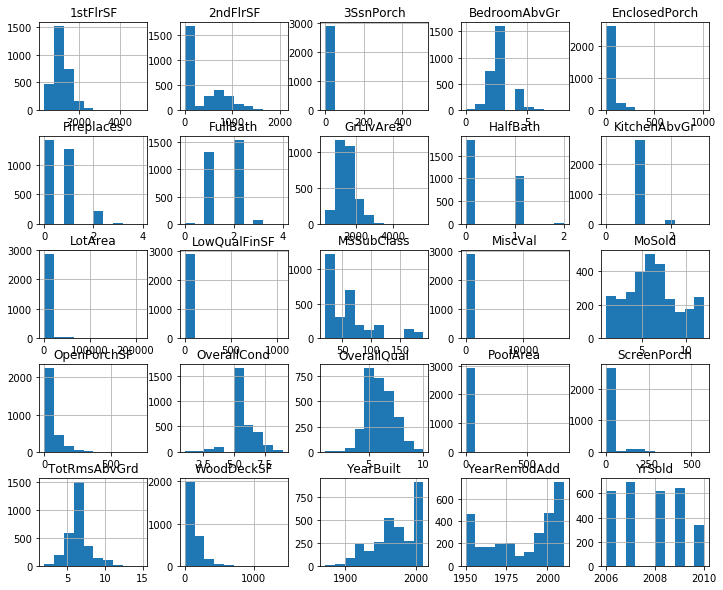

In [8]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

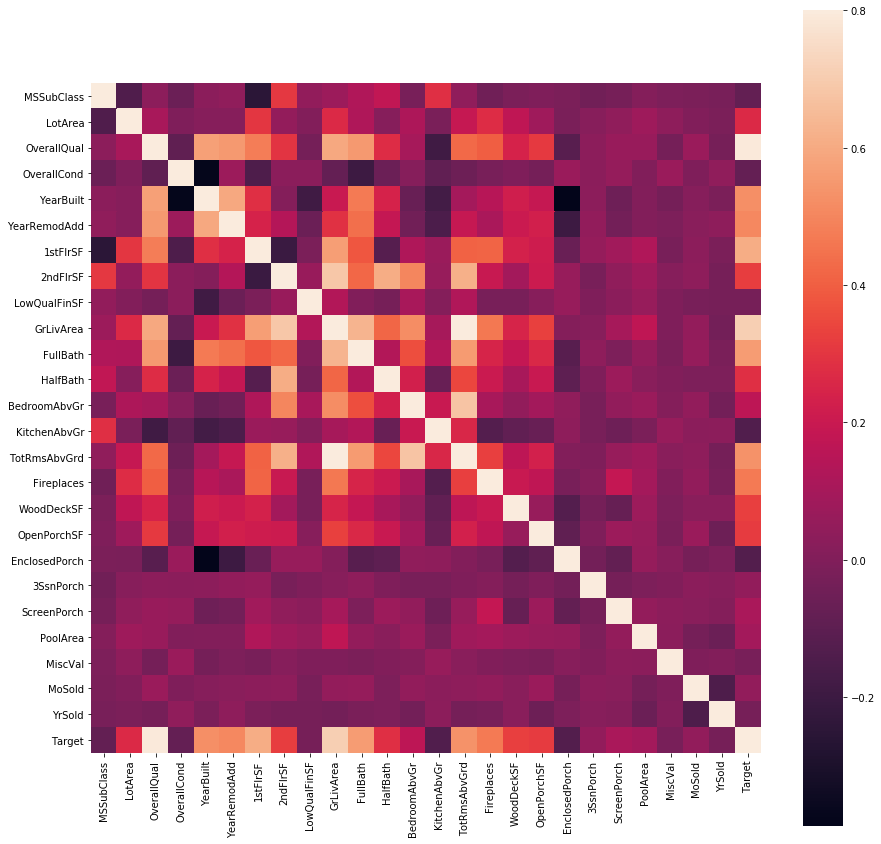

In [9]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [10]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [11]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
train, test = split_combined()

In [16]:
train.shape
test.shape

(1459, 149)

In [17]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0716 13:59:32.512219  8568 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 13:59:32.527179  8568 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 13:59:32.529174  8568 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0716 13:59:32.584027  8568 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               19200     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


In [18]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [19]:
NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0716 14:01:31.050629  8568 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0716 14:01:31.161361  8568 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1168 samples, validate on 292 samples
Epoch 1/500
1168/1168 [==============================] - 0s 301us/step - loss: 133559.4762 - mean_absolute_error: 133559.4762 - val_loss: 54424.1511 - val_mean_absolute_error: 54424.1511

Epoch 00001: val_loss improved from inf to 54424.15106, saving model to Weights-001--54424.15106.hdf5
Epoch 2/500
1168/1168 [==============================] - 0s 79us/step - loss: 53027.7985 - mean_absolute_error: 53027.7985 - val_loss: 47580.6520 - val_mean_absolute_error: 47580.6520

Epoch 00002: val_loss improved from 54424.15106 to 47580.65202, saving model to Weights-002--47580.65202.hdf5
Epoch 3/500
1168/1168 [==============================] - 0s 75us/step - loss: 44335.0593 - mean_absolute_error: 44335.0593 - val_loss: 43782.2445 - val_mean_absolute_error: 43782.2445

Epoch 00003: val_loss improved from 47580.65202 to 43782.24454, saving model to Weights-003--43782.24454.hdf5
Epoch 4/500
1168/1168 [==============================] - 0s 74us/step - l

Epoch 32/500
1168/1168 [==============================] - 0s 73us/step - loss: 30939.3214 - mean_absolute_error: 30939.3214 - val_loss: 34224.4992 - val_mean_absolute_error: 34224.4992

Epoch 00032: val_loss did not improve from 33712.50273
Epoch 33/500
1168/1168 [==============================] - 0s 73us/step - loss: 31163.2230 - mean_absolute_error: 31163.2230 - val_loss: 33191.2973 - val_mean_absolute_error: 33191.2973

Epoch 00033: val_loss improved from 33712.50273 to 33191.29730, saving model to Weights-033--33191.29730.hdf5
Epoch 34/500
1168/1168 [==============================] - 0s 78us/step - loss: 30790.4278 - mean_absolute_error: 30790.4278 - val_loss: 33910.4737 - val_mean_absolute_error: 33910.4737

Epoch 00034: val_loss did not improve from 33191.29730
Epoch 35/500
1168/1168 [==============================] - 0s 76us/step - loss: 31071.5286 - mean_absolute_error: 31071.5286 - val_loss: 32983.7641 - val_mean_absolute_error: 32983.7641

Epoch 00035: val_loss improved from 


Epoch 00064: val_loss improved from 30922.28264 to 30490.24823, saving model to Weights-064--30490.24823.hdf5
Epoch 65/500
1168/1168 [==============================] - 0s 73us/step - loss: 27072.0238 - mean_absolute_error: 27072.0238 - val_loss: 30716.5835 - val_mean_absolute_error: 30716.5835

Epoch 00065: val_loss did not improve from 30490.24823
Epoch 66/500
1168/1168 [==============================] - 0s 73us/step - loss: 28135.2778 - mean_absolute_error: 28135.2778 - val_loss: 32729.4532 - val_mean_absolute_error: 32729.4532

Epoch 00066: val_loss did not improve from 30490.24823
Epoch 67/500
1168/1168 [==============================] - 0s 74us/step - loss: 27120.1816 - mean_absolute_error: 27120.1816 - val_loss: 34390.6849 - val_mean_absolute_error: 34390.6849

Epoch 00067: val_loss did not improve from 30490.24823
Epoch 68/500
1168/1168 [==============================] - 0s 74us/step - loss: 28471.0532 - mean_absolute_error: 28471.0532 - val_loss: 29631.8301 - val_mean_absolute

1168/1168 [==============================] - 0s 73us/step - loss: 23681.8324 - mean_absolute_error: 23681.8324 - val_loss: 25865.8139 - val_mean_absolute_error: 25865.8139

Epoch 00096: val_loss improved from 26637.88731 to 25865.81389, saving model to Weights-096--25865.81389.hdf5
Epoch 97/500
1168/1168 [==============================] - 0s 69us/step - loss: 23148.5791 - mean_absolute_error: 23148.5791 - val_loss: 26397.8975 - val_mean_absolute_error: 26397.8975

Epoch 00097: val_loss did not improve from 25865.81389
Epoch 98/500
1168/1168 [==============================] - 0s 71us/step - loss: 25153.7368 - mean_absolute_error: 25153.7368 - val_loss: 29481.5113 - val_mean_absolute_error: 29481.5113

Epoch 00098: val_loss did not improve from 25865.81389
Epoch 99/500
1168/1168 [==============================] - 0s 73us/step - loss: 23512.5216 - mean_absolute_error: 23512.5216 - val_loss: 26349.9073 - val_mean_absolute_error: 26349.9073

Epoch 00099: val_loss did not improve from 25865.


Epoch 00127: val_loss did not improve from 23390.39892
Epoch 128/500
1168/1168 [==============================] - 0s 75us/step - loss: 19994.4452 - mean_absolute_error: 19994.4452 - val_loss: 25942.3672 - val_mean_absolute_error: 25942.3672

Epoch 00128: val_loss did not improve from 23390.39892
Epoch 129/500
1168/1168 [==============================] - 0s 73us/step - loss: 20616.8391 - mean_absolute_error: 20616.8391 - val_loss: 23881.8387 - val_mean_absolute_error: 23881.8387

Epoch 00129: val_loss did not improve from 23390.39892
Epoch 130/500
1168/1168 [==============================] - 0s 72us/step - loss: 22599.6730 - mean_absolute_error: 22599.6730 - val_loss: 23436.8742 - val_mean_absolute_error: 23436.8742

Epoch 00130: val_loss did not improve from 23390.39892
Epoch 131/500
1168/1168 [==============================] - 0s 73us/step - loss: 20938.4949 - mean_absolute_error: 20938.4949 - val_loss: 24011.1234 - val_mean_absolute_error: 24011.1234

Epoch 00131: val_loss did not i

1168/1168 [==============================] - 0s 84us/step - loss: 18508.5864 - mean_absolute_error: 18508.5864 - val_loss: 22072.6058 - val_mean_absolute_error: 22072.6058

Epoch 00161: val_loss improved from 22851.51060 to 22072.60584, saving model to Weights-161--22072.60584.hdf5
Epoch 162/500
1168/1168 [==============================] - 0s 75us/step - loss: 18294.5603 - mean_absolute_error: 18294.5603 - val_loss: 24250.3856 - val_mean_absolute_error: 24250.3856

Epoch 00162: val_loss did not improve from 22072.60584
Epoch 163/500
1168/1168 [==============================] - 0s 79us/step - loss: 19480.8301 - mean_absolute_error: 19480.8301 - val_loss: 22022.8302 - val_mean_absolute_error: 22022.8302

Epoch 00163: val_loss improved from 22072.60584 to 22022.83016, saving model to Weights-163--22022.83016.hdf5
Epoch 164/500
1168/1168 [==============================] - 0s 76us/step - loss: 18365.9737 - mean_absolute_error: 18365.9737 - val_loss: 24862.1046 - val_mean_absolute_error: 248

1168/1168 [==============================] - 0s 97us/step - loss: 17297.5257 - mean_absolute_error: 17297.5257 - val_loss: 26533.4849 - val_mean_absolute_error: 26533.4849

Epoch 00193: val_loss did not improve from 21187.07631
Epoch 194/500
1168/1168 [==============================] - 0s 89us/step - loss: 19123.3795 - mean_absolute_error: 19123.3795 - val_loss: 28389.5583 - val_mean_absolute_error: 28389.5583

Epoch 00194: val_loss did not improve from 21187.07631
Epoch 195/500
1168/1168 [==============================] - 0s 91us/step - loss: 17779.1597 - mean_absolute_error: 17779.1597 - val_loss: 21382.4778 - val_mean_absolute_error: 21382.4778

Epoch 00195: val_loss did not improve from 21187.07631
Epoch 196/500
1168/1168 [==============================] - 0s 88us/step - loss: 17038.8444 - mean_absolute_error: 17038.8444 - val_loss: 24499.6993 - val_mean_absolute_error: 24499.6993

Epoch 00196: val_loss did not improve from 21187.07631
Epoch 197/500
1168/1168 [=====================

1168/1168 [==============================] - 0s 110us/step - loss: 17150.9719 - mean_absolute_error: 17150.9719 - val_loss: 29741.5895 - val_mean_absolute_error: 29741.5895

Epoch 00227: val_loss did not improve from 21187.07631
Epoch 228/500
1168/1168 [==============================] - 0s 98us/step - loss: 17099.7809 - mean_absolute_error: 17099.7809 - val_loss: 24665.3121 - val_mean_absolute_error: 24665.3121

Epoch 00228: val_loss did not improve from 21187.07631
Epoch 229/500
1168/1168 [==============================] - 0s 98us/step - loss: 17964.4296 - mean_absolute_error: 17964.4296 - val_loss: 22458.1223 - val_mean_absolute_error: 22458.1223

Epoch 00229: val_loss did not improve from 21187.07631
Epoch 230/500
1168/1168 [==============================] - 0s 106us/step - loss: 17072.4552 - mean_absolute_error: 17072.4552 - val_loss: 21616.3687 - val_mean_absolute_error: 21616.3687

Epoch 00230: val_loss did not improve from 21187.07631
Epoch 231/500
1168/1168 [===================

1168/1168 [==============================] - 0s 118us/step - loss: 17602.9074 - mean_absolute_error: 17602.9074 - val_loss: 22123.0619 - val_mean_absolute_error: 22123.0619

Epoch 00260: val_loss did not improve from 19998.56807
Epoch 261/500
1168/1168 [==============================] - 0s 102us/step - loss: 18384.7873 - mean_absolute_error: 18384.7873 - val_loss: 21202.7850 - val_mean_absolute_error: 21202.7850

Epoch 00261: val_loss did not improve from 19998.56807
Epoch 262/500
1168/1168 [==============================] - 0s 103us/step - loss: 16337.0887 - mean_absolute_error: 16337.0887 - val_loss: 20206.3901 - val_mean_absolute_error: 20206.3901

Epoch 00262: val_loss did not improve from 19998.56807
Epoch 263/500
1168/1168 [==============================] - 0s 105us/step - loss: 16822.8783 - mean_absolute_error: 16822.8783 - val_loss: 20243.8397 - val_mean_absolute_error: 20243.8397

Epoch 00263: val_loss did not improve from 19998.56807
Epoch 264/500
1168/1168 [=================

1168/1168 [==============================] - 0s 130us/step - loss: 16331.3254 - mean_absolute_error: 16331.3254 - val_loss: 21811.3032 - val_mean_absolute_error: 21811.3032

Epoch 00294: val_loss did not improve from 19998.56807
Epoch 295/500
1168/1168 [==============================] - 0s 143us/step - loss: 15139.7961 - mean_absolute_error: 15139.7961 - val_loss: 23884.9816 - val_mean_absolute_error: 23884.9816

Epoch 00295: val_loss did not improve from 19998.56807
Epoch 296/500
1168/1168 [==============================] - 0s 113us/step - loss: 16238.3295 - mean_absolute_error: 16238.3295 - val_loss: 21485.3111 - val_mean_absolute_error: 21485.3111

Epoch 00296: val_loss did not improve from 19998.56807
Epoch 297/500
1168/1168 [==============================] - 0s 113us/step - loss: 16565.1798 - mean_absolute_error: 16565.1798 - val_loss: 24311.4449 - val_mean_absolute_error: 24311.4449

Epoch 00297: val_loss did not improve from 19998.56807
Epoch 298/500
1168/1168 [=================


Epoch 00327: val_loss improved from 19822.31336 to 19456.15245, saving model to Weights-327--19456.15245.hdf5
Epoch 328/500
1168/1168 [==============================] - 0s 117us/step - loss: 16437.0066 - mean_absolute_error: 16437.0066 - val_loss: 23314.4095 - val_mean_absolute_error: 23314.4095

Epoch 00328: val_loss did not improve from 19456.15245
Epoch 329/500
1168/1168 [==============================] - 0s 119us/step - loss: 17430.8666 - mean_absolute_error: 17430.8666 - val_loss: 20435.4455 - val_mean_absolute_error: 20435.4455

Epoch 00329: val_loss did not improve from 19456.15245
Epoch 330/500
1168/1168 [==============================] - 0s 118us/step - loss: 16679.6718 - mean_absolute_error: 16679.6718 - val_loss: 22609.0738 - val_mean_absolute_error: 22609.0738

Epoch 00330: val_loss did not improve from 19456.15245
Epoch 331/500
1168/1168 [==============================] - 0s 120us/step - loss: 17465.3023 - mean_absolute_error: 17465.3023 - val_loss: 21083.0879 - val_mean_

1168/1168 [==============================] - 0s 134us/step - loss: 15577.8719 - mean_absolute_error: 15577.8719 - val_loss: 20220.8577 - val_mean_absolute_error: 20220.8577

Epoch 00361: val_loss did not improve from 19456.15245
Epoch 362/500
1168/1168 [==============================] - 0s 131us/step - loss: 14646.7201 - mean_absolute_error: 14646.7201 - val_loss: 23255.1409 - val_mean_absolute_error: 23255.1409

Epoch 00362: val_loss did not improve from 19456.15245
Epoch 363/500
1168/1168 [==============================] - 0s 143us/step - loss: 16318.6860 - mean_absolute_error: 16318.6860 - val_loss: 21273.5700 - val_mean_absolute_error: 21273.5700

Epoch 00363: val_loss did not improve from 19456.15245
Epoch 364/500
1168/1168 [==============================] - 0s 127us/step - loss: 14751.4012 - mean_absolute_error: 14751.4012 - val_loss: 20433.9565 - val_mean_absolute_error: 20433.9565

Epoch 00364: val_loss did not improve from 19456.15245
Epoch 365/500
1168/1168 [=================


Epoch 00394: val_loss did not improve from 19351.83653
Epoch 395/500
1168/1168 [==============================] - 0s 113us/step - loss: 15758.7926 - mean_absolute_error: 15758.7926 - val_loss: 20877.8256 - val_mean_absolute_error: 20877.8256

Epoch 00395: val_loss did not improve from 19351.83653
Epoch 396/500
1168/1168 [==============================] - 0s 113us/step - loss: 14293.3637 - mean_absolute_error: 14293.3637 - val_loss: 21785.4616 - val_mean_absolute_error: 21785.4616

Epoch 00396: val_loss did not improve from 19351.83653
Epoch 397/500
1168/1168 [==============================] - 0s 112us/step - loss: 15013.1201 - mean_absolute_error: 15013.1201 - val_loss: 19739.2368 - val_mean_absolute_error: 19739.2368

Epoch 00397: val_loss did not improve from 19351.83653
Epoch 398/500
1168/1168 [==============================] - 0s 115us/step - loss: 16789.1917 - mean_absolute_error: 16789.1917 - val_loss: 23174.2593 - val_mean_absolute_error: 23174.2593

Epoch 00398: val_loss did n

1168/1168 [==============================] - 0s 133us/step - loss: 15298.0209 - mean_absolute_error: 15298.0209 - val_loss: 19161.6114 - val_mean_absolute_error: 19161.6114

Epoch 00428: val_loss improved from 19351.83653 to 19161.61135, saving model to Weights-428--19161.61135.hdf5
Epoch 429/500
1168/1168 [==============================] - 0s 120us/step - loss: 14162.6237 - mean_absolute_error: 14162.6237 - val_loss: 19948.9151 - val_mean_absolute_error: 19948.9151

Epoch 00429: val_loss did not improve from 19161.61135
Epoch 430/500
1168/1168 [==============================] - 0s 127us/step - loss: 13970.0825 - mean_absolute_error: 13970.0825 - val_loss: 19722.9796 - val_mean_absolute_error: 19722.9796

Epoch 00430: val_loss did not improve from 19161.61135
Epoch 431/500
1168/1168 [==============================] - 0s 122us/step - loss: 13681.9367 - mean_absolute_error: 13681.9367 - val_loss: 19321.2167 - val_mean_absolute_error: 19321.2167

Epoch 00431: val_loss did not improve from

1168/1168 [==============================] - 0s 132us/step - loss: 14670.4382 - mean_absolute_error: 14670.4382 - val_loss: 22505.8635 - val_mean_absolute_error: 22505.8635

Epoch 00461: val_loss did not improve from 18702.27911
Epoch 462/500
1168/1168 [==============================] - 0s 133us/step - loss: 15302.1612 - mean_absolute_error: 15302.1612 - val_loss: 20839.1551 - val_mean_absolute_error: 20839.1551

Epoch 00462: val_loss did not improve from 18702.27911
Epoch 463/500
1168/1168 [==============================] - 0s 129us/step - loss: 13396.9526 - mean_absolute_error: 13396.9526 - val_loss: 19954.6622 - val_mean_absolute_error: 19954.6622

Epoch 00463: val_loss did not improve from 18702.27911
Epoch 464/500
1168/1168 [==============================] - 0s 128us/step - loss: 13845.7957 - mean_absolute_error: 13845.7957 - val_loss: 19199.5225 - val_mean_absolute_error: 19199.5225

Epoch 00464: val_loss did not improve from 18702.27911
Epoch 465/500
1168/1168 [=================

1168/1168 [==============================] - 0s 145us/step - loss: 13724.3632 - mean_absolute_error: 13724.3632 - val_loss: 19794.0893 - val_mean_absolute_error: 19794.0893

Epoch 00495: val_loss did not improve from 18702.27911
Epoch 496/500
1168/1168 [==============================] - 0s 144us/step - loss: 13867.2516 - mean_absolute_error: 13867.2516 - val_loss: 20082.9207 - val_mean_absolute_error: 20082.9207

Epoch 00496: val_loss did not improve from 18702.27911
Epoch 497/500
1168/1168 [==============================] - 0s 138us/step - loss: 14168.6195 - mean_absolute_error: 14168.6195 - val_loss: 19304.8376 - val_mean_absolute_error: 19304.8376

Epoch 00497: val_loss did not improve from 18702.27911
Epoch 498/500
1168/1168 [==============================] - 0s 131us/step - loss: 12880.1158 - mean_absolute_error: 12880.1158 - val_loss: 20612.7639 - val_mean_absolute_error: 20612.7639

Epoch 00498: val_loss did not improve from 18702.27911
Epoch 499/500
1168/1168 [=================

In [20]:
# Load wights file of the best model :
wights_file = 'Weights-439--19123.08027.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [23]:
def make_submission(prediction, sub_name):
    my_submission = pd.DataFrame({'Id':pd.read_csv('D:/project/contest/data/dlnn/test.csv').Id,'SalePrice':prediction})
    my_submission.to_csv('D:/project/contest/data/dlnn/{}.csv'.format(sub_name),index=False)
    print('A submission file has been made')

predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission(NN).csv')

A submission file has been made


In [24]:
train_X, val_X, train_y, val_y = train_test_split(train, target, test_size = 0.25, random_state = 14)

In [25]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
predicted_prices = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  19419.97315068493


In [27]:
predicted_prices = model.predict(test)
make_submission(predicted_prices,'Submission(RF).csv')

A submission file has been made


In [28]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

[14:29:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  17869.75410958904


In [29]:
XGBpredictions = XGBModel.predict(test)
make_submission(XGBpredictions,'Submission(XGB).csv')

A submission file has been made
